## Import Libraries

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import json
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from transformers import DataCollatorForTokenClassification

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

# from torchsummary import summary

C:\Users\Rofif\anaconda3\envs\lexidvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


## Define NER Label

In [ ]:
# Info: Transformers (huggingface) is quite different from pytorch
label_names = ["O", "B-LEG", "I-LEG", "B-NUM", "I-NUM",
                   "B-YER", "I-YER", "B-PAS", "I-PAS", "B-AYT", "I-AYT"]
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

## Download Model

In [ ]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline

# pipe = pipeline("token-classification", model="kiipliwooke/KIPBERT")

# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("kiipliwooke/KIPBERT")
model = AutoModelForTokenClassification.from_pretrained("kiipliwooke/KIPBERT")

In [ ]:
pipe("Bagaimana bunyi Pasal 23 dalam Peraturan Pemerintah Republik Indonesia Nomor 87 Tahun 2013")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'B-LAW',
  'score': 0.72627443,
  'index': 3,
  'word': 'pasal',
  'start': 16,
  'end': 21},
 {'entity': 'I-LAW',
  'score': 0.8700874,
  'index': 4,
  'word': '23',
  'start': 22,
  'end': 24},
 {'entity': 'B-LAW',
  'score': 0.8670925,
  'index': 6,
  'word': 'peraturan',
  'start': 31,
  'end': 40},
 {'entity': 'I-LAW',
  'score': 0.95574975,
  'index': 7,
  'word': 'pemerintah',
  'start': 41,
  'end': 51},
 {'entity': 'I-LAW',
  'score': 0.96602213,
  'index': 8,
  'word': 'republik',
  'start': 52,
  'end': 60},
 {'entity': 'I-LAW',
  'score': 0.96785,
  'index': 9,
  'word': 'indonesia',
  'start': 61,
  'end': 70},
 {'entity': 'I-LAW',
  'score': 0.9666635,
  'index': 10,
  'word': 'nomor',
  'start': 71,
  'end': 76},
 {'entity': 'I-LAW',
  'score': 0.9754229,
  'index': 11,
  'word': '87',
  'start': 77,
  'end': 79},
 {'entity': 'I-LAW',
  'score': 0.96985763,
  'index': 12,
  'word': 'tahun',
  'start': 80,
  'end': 85},
 {'entity': 'I-LAW',
  'score': 0.977816

## Save Model to local - Example

In [ ]:
# save_path = 'model/'

# model_ner_path = os.path.join(save_path, "indobert_ner"+".pth")

# torch.save(model_ner, model_ner_path)

## Load Model - Example

In [ ]:
# save_path = 'model/'
# model_ner_path = os.path.join(save_path, "indobert_ner"+".pth")

# bert_ner = torch.load(model_ner_path)

# bert_ner = pipe
bert_ner = model

In [ ]:
bert_ner.config.num_labels

39

In [ ]:
bert_ner.config.id2label

{0: 'B-CRD',
 1: 'B-DAT',
 2: 'B-EVT',
 3: 'B-FAC',
 4: 'B-GPE',
 5: 'B-LAN',
 6: 'B-LAW',
 7: 'B-LOC',
 8: 'B-MON',
 9: 'B-NOR',
 10: 'B-ORD',
 11: 'B-ORG',
 12: 'B-PER',
 13: 'B-PRC',
 14: 'B-PRD',
 15: 'B-QTY',
 16: 'B-REG',
 17: 'B-TIM',
 18: 'B-WOA',
 19: 'I-CRD',
 20: 'I-DAT',
 21: 'I-EVT',
 22: 'I-FAC',
 23: 'I-GPE',
 24: 'I-LAN',
 25: 'I-LAW',
 26: 'I-LOC',
 27: 'I-MON',
 28: 'I-NOR',
 29: 'I-ORD',
 30: 'I-ORG',
 31: 'I-PER',
 32: 'I-PRC',
 33: 'I-PRD',
 34: 'I-QTY',
 35: 'I-REG',
 36: 'I-TIM',
 37: 'I-WOA',
 38: 'O'}

In [ ]:
print(bert_ner)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

# LexID QA 2 Using BERT

## Dataset Class

In [ ]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"Other": 0, "LAW": 1}
    self.id2label = {0: "Other", 1: "LAW"}

    self.classlabel2id = {"T1": 0, "T2": 1, "T3": 2, "T4": 3,
                "T5": 4, "T6": 5, "T7": 6, "T8": 7, "T9": 8,
                "T10": 9, "T11": 10, "T12": 11, "T13": 12,
                "T14": 13, "T15": 14, "T16": 15, "T17": 16, "T18": 17}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = tokenizer(question, truncation=True)
    question_input_ids = torch.Tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.Tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.Tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    ner = torch.Tensor(json.loads(self.qa_frame.loc[idx, "ner"])).int()
    ner = self.align_labels_with_tokens(ner, question_tokenized.word_ids(), question_tokenized.tokens(), question)
    class_label = torch.Tensor([self.classlabel2id[self.qa_frame.loc[idx, "template_index"]]])

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              ner,
              class_label)

    return sample

  def align_labels_with_tokens(self, labels, word_ids, tokens, question):
    for index, token in enumerate(tokens):
      if token == '-':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == '/':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif token == ',':
        for i in range(index, len(word_ids)):
          if word_ids[i] is not None:
            word_ids[i] -= 1
      elif tokens[index-1] == '-':  # Because the '-' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != '-': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1
      elif tokens[index-1] == '/':  # Because the '/' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != '/': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1
      elif tokens[index-1] == ',':  # Because the ',' have been deleted
        id = word_ids[index-1]
        if question.split(' ')[id][-1] != ',': # Check if the gold question concatenated between the special character or not
          for i in range(index, len(word_ids)):
            if word_ids[i] is not None:
              word_ids[i] -= 1

    new_labels = []
    current_word = None
    for word_id in word_ids:
      if word_id != current_word:
        # Start of a new word!
        current_word = word_id
        label = -100 if word_id is None else labels[word_id]
        new_labels.append(label)
      elif word_id is None:
        # Special token
        new_labels.append(-100)
      else:
        # Same word as previous token
        label = labels[word_id]
        new_labels.append(label)

    return torch.Tensor(new_labels)

## Merging Dataset from Different csv

In [ ]:
t1 = pd.read_csv("tesaurus/t1_dataset_tesaurus.csv")
num, _ = t1.shape
num

12155

In [ ]:
t = pd.DataFrame()
for i in range(1, 19):
  read_path = "tesaurus/t" + str(i) + "_dataset_tesaurus.csv"
  t_index = pd.read_csv(read_path)

  num_row, _ = t_index.shape
  two_thousands = np.min([2000, num_row])
  t = pd.concat([t, t_index[:two_thousands]], ignore_index=True)

# t1 = pd.read_csv("t1_dataset.csv")
# t2 = pd.read_csv("t2_dataset.csv")
# t3 = pd.read_csv("t3_dataset.csv")
# t4 = pd.read_csv("t4_dataset.csv")
# t5 = pd.read_csv("t5_dataset.csv")

# t1['template_index'] = "T1"
# t2['template_index'] = "T2"
# t3['template_index'] = "T3"
# t4['template_index'] = "T4"
# t5['template_index'] = "T5"

# t = pd.concat([t1, t2, t3, t4, t5], ignore_index=True)
t.head()

,question,answer,ner,legal_document,query,template_index,pasal_num,ayat_num
0,Peraturan Daerah Kota Semarang Nomor 6 Tahun 2...,H Sukawi Sutarip,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]",https://w3id.org/lex-id/data/Perkot_Semarang_2...,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
1,Pelegal dari Peraturan Presiden Republik Indon...,Joko Widodo,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]",https://w3id.org/lex-id/data/Perpres_2019_89,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
2,Peraturan Menteri Pertahanan Republik Indonesi...,Ryamizard Ryacudu,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]",https://w3id.org/lex-id/data/Permen_Han_2016_37,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
3,Keabsahan Peraturan Daerah Kabupaten Wakatobi ...,H U G U A,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",https://w3id.org/lex-id/data/Perkab_Wakatobi_2...,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
4,Status Peraturan Pemerintah Republik Indonesia...,Dr Hamid Awaludin,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",https://w3id.org/lex-id/data/PP_2005_6,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN


## Dataset

In [ ]:
qa_dataset = Lexidqa2Dataset(t, tokenizer)

Sample

In [ ]:
tokenizer("Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa").tokens()

['[CLS]',
 'undang',
 '-',
 'undang',
 'republik',
 'indonesia',
 'nomor',
 '7',
 'tahun',
 '1967',
 'dibuat',
 'dengan',
 'menimbang',
 '-',
 'nim',
 '##bang',
 'apa',
 '[SEP]']

In [ ]:
tokenizer("Apakah Peraturan Menteri Keuangan Republik Indonesia Nomor 218 Tahun 2014 ini pernah diameliorasi").tokens()

['[CLS]',
 'apakah',
 'peraturan',
 'menteri',
 'keuangan',
 'republik',
 'indonesia',
 'nomor',
 '21',
 '##8',
 'tahun',
 '2014',
 'ini',
 'pernah',
 'diam',
 '##eli',
 '##orasi',
 '[SEP]']

In [ ]:
print(qa_dataset[7179])

Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa
['[CLS]', 'undang', '-', 'undang', 'republik', 'indonesia', 'nomor', '7', 'tahun', '1967', 'dibuat', 'dengan', 'menimbang', '-', 'nim', '##bang', 'apa', '[SEP]']
('Undang-Undang Republik Indonesia Nomor 7 Tahun 1967 dibuat dengan menimbang-nimbang apa', tensor([3.0000e+00, 2.6130e+03, 1.7000e+01, 2.6130e+03, 3.4890e+03, 1.7180e+03,
        3.2860e+03, 2.7000e+01, 1.6200e+03, 8.9900e+03, 3.2300e+03, 1.5450e+03,
        1.7572e+04, 1.7000e+01, 1.8615e+04, 2.0960e+03, 2.0640e+03, 4.0000e+00]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), '1. Bahwa dipandang perlu memberikan penghargaan kepada mereka yang telah menyumbangkan tenaganya secara aktif atas dasar sukarela dalam ikatan kesatuan bersenjata (resmi maupun kelaskaran) dalam memperjuangkan, membela dan mempertahankan Kemerdekaan N

In [ ]:
for i in range(len(qa_dataset)):
  sample = qa_dataset[i]

  print(i, sample[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(qa_dataset)), size=5, replace=False)

for i in random_indices:
  sample = qa_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

5710 Kapan terjadinya pengukugannya Peraturan Menteri Keuangan Republik Indonesia Nomor 204 Tahun 2015 ini keluar
21038 Apakah isi Pasal 2 dalam Peraturan Menteri Kelautan Dan Perikanan Republik Indonesia Nomor 25 Tahun 2012 itu
19978 Berapa jumlah pasal yang tersusun di Peraturan Pemerintah Republik Indonesia Nomor 26 Tahun 2016 tersebut
29131 Sudahkah Peraturan Menteri Perhubungan Republik Indonesia Nomor 41 Tahun 2012 tersebut dilakukan penyempurnaan
26026 Peraturan Komisi Pemilihan Umum Republik Indonesia Nomor 10 Tahun 2015 tersebut terjadi penganuliran pasal-pasal mana saja


## Split, DataLoader

In [ ]:
torch.manual_seed(0)

train_size = int(0.5 * len(qa_dataset))
val_size = int(0.6 * (len(qa_dataset) - train_size))
test_size = len(qa_dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(qa_dataset, [train_size, val_size, test_size])

In [ ]:
# train_df = pd.read_csv('train_tesaurus.csv')
test_df = pd.read_csv('test_tesaurus.csv')

# train_dataset = Lexidqa2Dataset(train_df, tokenizer)
test_dataset = Lexidqa2Dataset(test_df, tokenizer)

In [ ]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, _, _, ner_labels, class_labels = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    targets = pad_sequence(ner_labels, batch_first=True, padding_value=-100)
    target_classes = pad_sequence(class_labels, batch_first=True, padding_value=-100)
    return features, targets, target_classes

    # max_len = max(lengths)
    # n_ftrs = data[0][0].size(1)
    # features = torch.zeros((len(data), max_len, n_ftrs))
    # labels = torch.tensor(labels)
    # lengths = torch.tensor(lengths)

    # for i in range(len(data)):
    #     j, k = data[i][0].size(0), data[i][0].size(1)
    #     features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    # return features.float(), labels.long(), lengths.long()

In [ ]:
torch.manual_seed(0)
BATCH_SIZE = 64

# train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
# valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)
test_instances = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_instances = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Extract Entity

In [ ]:
# prediction in the form: list of dictionary
def extract_entity(prediction, tokens):
  sequence_length = len(tokens)

  current_index = -1
  sentence = ''
  ner = []
  entities = []

  for index, (entity_token, entity_word) in enumerate(zip(prediction, tokens)):
    if entity_word in ['[CLS]', '[SEP]', '[PAD]']:
      ner.append(-100)
      continue
    if entity_token == 6: # 6 is B-LAW
      ner.append(1)
      if sentence != '':
        entities.append(sentence)
        sentence = ''
      current_index = index
      sentence = entity_word
    elif entity_token == 25:  # 25 is I-LAW
      ner.append(1)
      if index == current_index + 1:
        current_index = index
        sentence += ' ' +  entity_word
    else:
      ner.append(0)

  if sentence != '':
    entities.append(sentence)
    sentence = ''

  if len(ner) < sequence_length:
    ner.append([0 for i in range(sequence_length - len(ner))])

  return entities, ner

# Evaluation Function

Evaluation based on exact match of entity

I.E. If start and till the end tokens exactly cover the chunk of entity

In [ ]:
# pred and gold expected in torch in batch, in ner format, only 0 and 1
def confusion_matrix(pred, gold, conf_matrix):
  for p, g in zip(pred, gold):
    conf_matrix = compute_confusion_matrix_unit(p, g, conf_matrix)

  return conf_matrix

def compute_confusion_matrix_unit(pred, gold, conf_matrix):
  for i, (p, g) in reversed(list(enumerate(zip(pred.copy(), gold.copy())))):
    if p == -100 and g == -100:
      del pred[i], gold[i]

  current_index = -1
  current_ner_label = -1
  start_index = -1

  for g in gold:
    if g != current_ner_label:
      if current_index == -1:
        current_index = 0
        start_index = 0
        current_ner_label = g
      else:
        complete_cycle = False
        for i in range(start_index, current_index + 1):
          if pred[i] != current_ner_label:
            conf_matrix[current_ner_label, pred[i]] += 1
            complete_cycle = True
            break
        if not complete_cycle:
          conf_matrix[current_ner_label, current_ner_label] += 1
        current_index += 1
        start_index = current_index
        current_ner_label = g
    else:
      current_index += 1

  complete_cycle = False
  for i in range(start_index, current_index + 1):
    if pred[i] != current_ner_label:
      conf_matrix[current_ner_label, pred[i]] += 1
      complete_cycle = True
      break
  if not complete_cycle:
    conf_matrix[current_ner_label, current_ner_label] += 1

  return conf_matrix

In [ ]:
def evaluation_metric(conf_matrix):
  nb_classes = 2
  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 2

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_positive += conf_matrix[index, col]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 2

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_negative += conf_matrix[col, index]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 2

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

# Evaluation Function, Accuracy Version

In [ ]:
# pred and gold expected in torch in batch, in ner format, only 0 and 1
def confusion_matrix_acc(pred, gold, conf_matrix):
  for p, g in zip(pred, gold):
    conf_matrix = compute_confusion_matrix_acc_unit(p, g, conf_matrix)

  return conf_matrix

def compute_confusion_matrix_acc_unit(pred, gold, conf_matrix):
  for i, (p, g) in reversed(list(enumerate(zip(pred.copy(), gold.copy())))):
    if p == -100 and g == -100:
      del pred[i], gold[i]

  if pred == gold:
    conf_matrix[0] += 1
  else:
    conf_matrix[1] += 1

  return conf_matrix

# Testing

In [ ]:
torch.manual_seed(0)

tr_loss = 0

bert_ner.to(DEVICE)
bert_ner.eval()

nb_classes = 2
nb_classes_template = 18

conf_matrix = [torch.zeros(nb_classes) for i in range(nb_classes_template)]
# conf_matrix = torch.zeros(nb_classes, nb_classes)

# Untuk setiap data di training data
for data in test_instances:

  with torch.no_grad():
    # Mendapatkan output dari model
    input, gold, classes = data
    input = input.to(DEVICE).long()
    gold = gold.to(DEVICE)
    logits = bert_ner(input).logits
    pred = torch.argmax(logits, dim=2)

    entities = []
    ners = []
    for p, i in zip(pred, input):
      entity, ner = extract_entity(p, tokenizer.convert_ids_to_tokens(i))
      entities.append(entity)
      ners.append(ner)

    pred = torch.Tensor(ners)

    for i in range(nb_classes_template):
      indices = np.where(classes == i)[0]
      conf_matrix[i] = confusion_matrix_acc(pred[indices].int().tolist(), gold[indices].int().tolist(), conf_matrix[i])

amt, acc, prec, rec, f1 = [], [], [], [], []
# for i in range(nb_classes_template):
#   amt_loop, acc_loop, prec_loop, rec_loop, f1_loop = evaluation_metric(conf_matrix[i])
#   amt.append(amt_loop)
#   acc.append(acc_loop)
#   prec.append(prec_loop)
#   rec.append(rec_loop)
#   f1.append(f1_loop)
# accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)
print(f"Confusion Matrix in testing data: ")

for i in range(nb_classes_template):

  # fig, ax = plt.subplots(figsize=(10, 5))

  display_labels = ['LAW']
  # disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix[i].detach().cpu().numpy(), display_labels=display_labels)
  # disp.plot(ax=ax)

  # plt.title(f"Template Label {i}")
  # plt.show()

  for j, template_index in enumerate(display_labels):
      print(f"Evaluation for Template Label {i}:")
      print(f"Amount of Data: {[conf_matrix[i][0].item() + conf_matrix[j][1].item()]}")
      print(f"Accuracy: {conf_matrix[i][0].item() / (conf_matrix[i][0].item() + conf_matrix[i][1].item())}")
      # print(f"Precision: {prec[i][j]}")
      # print(f"Recall: {rec[i][j]}")
      # print(f"F One: {f1[i][j]}")
      print()

display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
# Only get the LAW labels (index 1) and its in tensor format
data_conf = data_conf = {
        'Amount of Data': [lst[0].item() + lst[1].item() for lst in conf_matrix],
        'Accuracy': [lst[0].item() / (lst[0].item() + lst[1].item()) for lst in conf_matrix],
        # 'Precision': [lst[1].item() for lst in prec],
        # 'Recall': [lst[1].item() for lst in rec],
        # 'F One': [lst[1].item() for lst in f1]
    }
disp_df = pd.DataFrame(data=data_conf,
                        index=display_labels, columns=['Amount of Data', 'Accuracy'])
display(disp_df)

Confusion Matrix in testing data: 
Evaluation for Template Label 0:
Amount of Data: [500.0]
Accuracy: 0.952

Evaluation for Template Label 1:
Amount of Data: [524.0]
Accuracy: 1.0

Evaluation for Template Label 2:
Amount of Data: [524.0]
Accuracy: 1.0

Evaluation for Template Label 3:
Amount of Data: [508.0]
Accuracy: 0.968

Evaluation for Template Label 4:
Amount of Data: [524.0]
Accuracy: 1.0

Evaluation for Template Label 5:
Amount of Data: [524.0]
Accuracy: 1.0

Evaluation for Template Label 6:
Amount of Data: [513.0]
Accuracy: 0.978

Evaluation for Template Label 7:
Amount of Data: [520.0]
Accuracy: 0.992

Evaluation for Template Label 8:
Amount of Data: [522.0]
Accuracy: 0.996

Evaluation for Template Label 9:
Amount of Data: [524.0]
Accuracy: 1.0

Evaluation for Template Label 10:
Amount of Data: [451.0]
Accuracy: 0.854

Evaluation for Template Label 11:
Amount of Data: [458.0]
Accuracy: 0.868

Evaluation for Template Label 12:
Amount of Data: [24.0]
Accuracy: 0.0

Evaluation fo

,Amount of Data,Accuracy
T1,500.0,0.952000
T2,500.0,1.000000
T3,500.0,1.000000
T4,500.0,0.968000
T5,500.0,1.000000
T6,500.0,1.000000
T7,500.0,0.978000
T8,500.0,0.992000
T9,500.0,0.996000
T10,500.0,1.000000


# Archive

## Testing

Debug Amount: tensor([11344.,  7535.])
Confusion Matrix in testing data: 


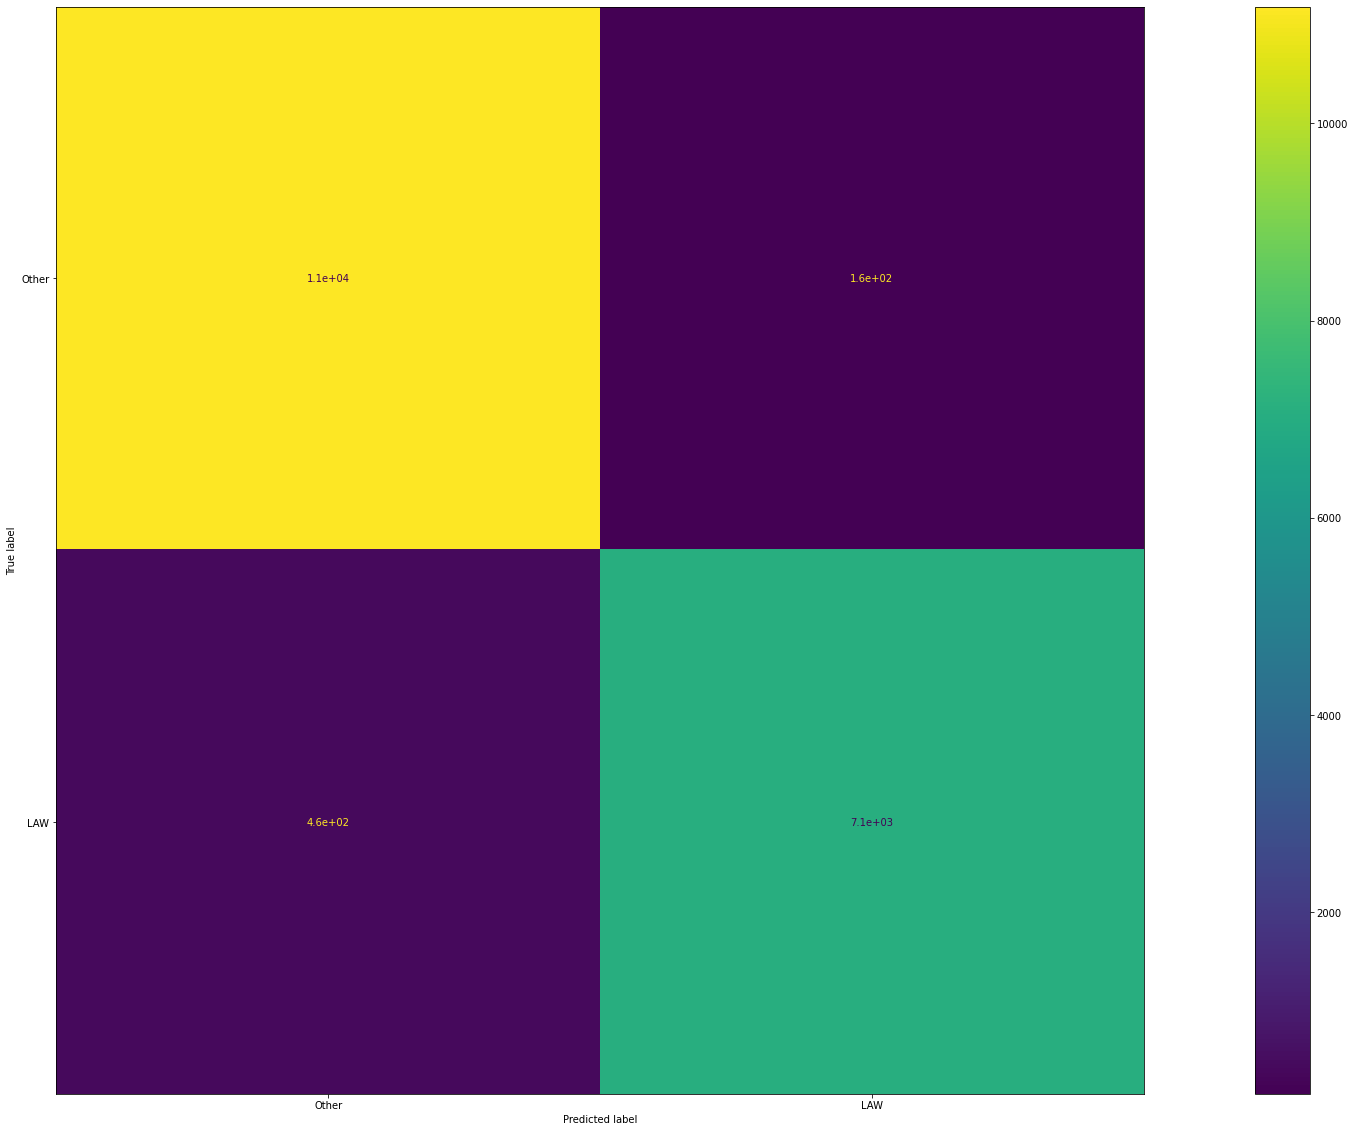

Evaluation for Other label:
Amount of Data: 11344.0
Accuracy: 0.985807478427887
Precision: 0.985807478427887
Recall: 0.9605737924575806
F One: 0.9730270504951477

Evaluation for LAW label:
Amount of Data: 7535.0
Accuracy: 0.9390842914581299
Precision: 0.9390842914581299
Recall: 0.977753221988678
F One: 0.9580287337303162



In [ ]:
torch.manual_seed(0)

tr_loss = 0

bert_ner.to(DEVICE)
bert_ner.eval()

nb_classes = 2

conf_matrix = torch.zeros(nb_classes, nb_classes)
# Untuk setiap data di training data
for data in test_instances:

  with torch.no_grad():
    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE).long()
    gold = gold.to(DEVICE)
    logits = bert_ner(input).logits
    pred = torch.argmax(logits, dim=2)

    entities = []
    ners = []
    for p, i in zip(pred, input):
      entity, ner = extract_entity(p, tokenizer.convert_ids_to_tokens(i))
      entities.append(entity)
      ners.append(ner)

    pred = torch.Tensor(ners)

    conf_matrix = confusion_matrix(pred.int().tolist(), gold.int().tolist(), conf_matrix)

amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
# accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)
print(f"Confusion Matrix in testing data: ")

fig, ax = plt.subplots(figsize=(40, 20))

display_labels = ['Other', 'LAW']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
disp.plot(ax=ax)

plt.show()

for i, template_index in enumerate(display_labels):
    print(f"Evaluation for {template_index} label:")
    print(f"Amount of Data: {amt[i]}")
    print(f"Accuracy: {acc[i]}")
    print(f"Precision: {prec[i]}")
    print(f"Recall: {rec[i]}")
    print(f"F One: {f1[i]}")
    print()